In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.decomposition import PCA

import keras
from keras.models import Sequential
from keras.layers import Dense
import time
from keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint

%matplotlib inline
sns.set_style('whitegrid')

# Suppress warnings from pandas
import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [2]:
#Read 3 Dataset: Application Train/Test & Previous Application
app_train = pd.read_csv('C:/Users/thang/Documents/Thangamani/BITS Pilani/Fourth Sem/Home_loan_repayment/data/Home_loan/application_train.csv',na_values=['?', 'nan','XNA'])
app_test = pd.read_csv('C:/Users/thang/Documents/Thangamani/BITS Pilani/Fourth Sem/Home_loan_repayment/data/Home_loan/application_test.csv',na_values=['?', 'nan','XNA'])
previous_application = pd.read_csv('C:/Users/thang/Documents/Thangamani/BITS Pilani/Fourth Sem/Home_loan_repayment/data/Home_loan/previous_application.csv',na_values=['?', 'nan','XNA'])

#Add column to identify if the dataset is a training or test dataset
app_test['is_test'] = 1.
app_test['is_train'] = 0.
app_train['is_test'] = 0.
app_train['is_train'] = 1.

# Move Target column to the last column of Train Dataset
Y = app_train['TARGET']
app_train = app_train.drop(['TARGET'], axis = 1)
app_train = pd.concat([app_train, Y], axis=1)

#Add Target column in Test Dataset
app_test['TARGET'] = 0.

test_X = app_test
train_X = app_train

#Merge train and test datasets for preprocessing
data = pd.concat([train_X, test_X], axis=0)
print('Combined Application Train and Test Dataset:  ', data.shape)

Combined Application Train and Test Dataset:   (356255, 124)


## Quick Data Exploration

## 1. Imbalance of Target Variable

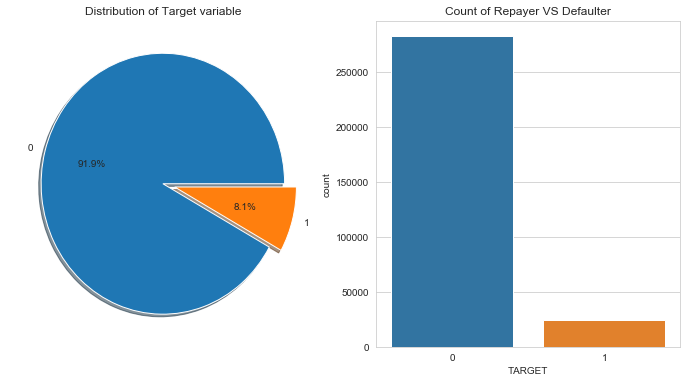

In [3]:
f,ax=plt.subplots(1,2,figsize=(12,6))
app_train.TARGET.value_counts().plot.pie(explode=[0,0.1],autopct='%1.1f%%',ax=ax[0],shadow=True)
ax[0].set_title('Distribution of Target variable')
ax[0].set_ylabel('')
sns.countplot('TARGET',data=app_train,ax=ax[1])
ax[1].set_title('Count of Repayer VS Defaulter')
plt.show()

## 2. Collinear Features

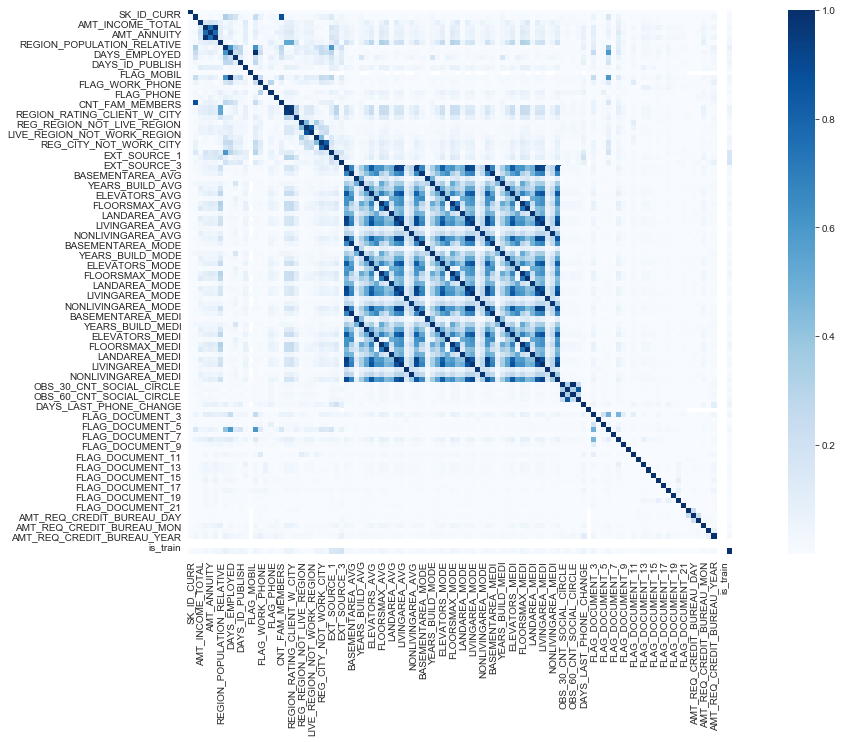

In [4]:
colormap = sns.diverging_palette(220, 10, as_cmap = True)
corr = app_train.corr().abs()
fig, ax = plt.subplots(figsize=(20, 10))
sns.heatmap(corr, cmap = "Blues", square=True)

## 3. Missing Data

Text(0.5,1,'Percent missing data by feature')

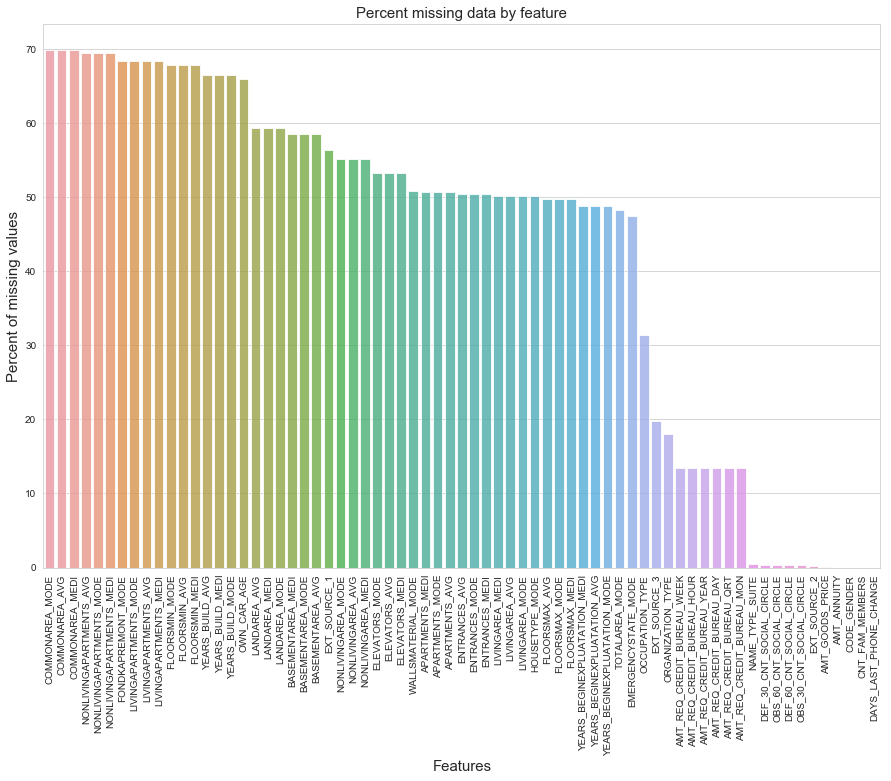

In [5]:
total = app_train.isnull().sum().sort_values(ascending = False)
percent = (app_train.isnull().sum()/app_train.isnull().count()*100).sort_values(ascending = False)
ms=pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
ms= ms[ms["Percent"] > 0]
f,ax =plt.subplots(figsize=(15,10))
plt.xticks(rotation='90')
fig=sns.barplot(ms.index, ms["Percent"],alpha=0.8)
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature', fontsize=15)


In [6]:
ms

,Total,Percent
COMMONAREA_MODE,214865,69.872297
COMMONAREA_AVG,214865,69.872297
COMMONAREA_MEDI,214865,69.872297
NONLIVINGAPARTMENTS_AVG,213514,69.432963
NONLIVINGAPARTMENTS_MODE,213514,69.432963
NONLIVINGAPARTMENTS_MEDI,213514,69.432963
FONDKAPREMONT_MODE,210295,68.386172
LIVINGAPARTMENTS_MODE,210199,68.354953
LIVINGAPARTMENTS_AVG,210199,68.354953
LIVINGAPARTMENTS_MEDI,210199,68.354953


## Preprocessing

## 1. Encoding of Categoral Columns

In [7]:
#Encode Categorical columns of Application Dataset
feats = [col for col in list(data.columns) if data[col].dtype == 'object']
for col in feats:
    data = pd.concat([data, pd.get_dummies(data[col], prefix=col)], axis=1)
data.drop(feats, axis =1, inplace = True)

In [8]:
#Encode Categorical columns of Previous Application Dataset
feats1 = [col for col in list(previous_application.columns) if previous_application[col].dtype == 'object']
for col in feats1:
    previous_application = pd.concat([previous_application, pd.get_dummies(previous_application[col], prefix=col)], axis=1)
previous_application.drop(feats1, axis =1, inplace = True)

In [9]:
print('Current Application Dataset after encoding :  ', data.shape)
print('Previous Application Dateset after encoding: ', previous_application.shape)

Current Application Dataset after encoding :   (356255, 246)
Previous Application Dateset after encoding:  (1670214, 154)


## 2. Joining of Dataset

In [10]:
prev_app_count = previous_application[['SK_ID_CURR', 'SK_ID_PREV']].groupby('SK_ID_CURR').count()
previous_application['SK_ID_PREV'] = previous_application['SK_ID_CURR'].map(prev_app_count['SK_ID_PREV'])

## Average values for all other features in previous applications
prev_app_avg = prev_app_count.groupby('SK_ID_CURR').mean()
prev_app_avg.columns = ['p_' + col for col in prev_app_avg.columns]
data_all = data.merge(right=prev_app_avg.reset_index(), how='left', on='SK_ID_CURR')
print('Merged Current and Previous Application Dataset: ',data_all.shape)

Merged Current and Previous Application Dataset:  (356255, 247)


## Feature Selection

## 1. Remove Collinear Features

In [11]:
# Threshold for removing correlated variables
threshold = 0.8

# Absolute value correlation matrix
corr_matrix = data_all.corr().abs()
corr_matrix.head()

,SK_ID_CURR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,...,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,p_SK_ID_PREV
SK_ID_CURR,1.000000,0.000879,0.001605,0.000423,0.000630,0.000531,0.001190,0.000976,0.001046,0.000698,...,0.000145,0.001658,0.000467,0.001243,0.001789,0.000107,0.000539,0.001042,0.002122,0.002353
CNT_CHILDREN,0.000879,1.000000,0.014067,0.005988,0.025988,0.002243,0.024205,0.329198,0.239654,0.182230,...,0.005194,0.001475,0.001703,0.000690,0.018909,0.024217,0.009792,0.036355,0.004055,0.028913
AMT_INCOME_TOTAL,0.001605,0.014067,1.000000,0.166590,0.204391,0.169445,0.081087,0.028313,0.068292,0.029715,...,0.012830,0.005985,0.025391,0.003965,0.034717,0.016735,0.003601,0.052812,0.002979,0.030996
AMT_CREDIT,0.000423,0.005988,0.166590,1.000000,0.762521,0.987159,0.103423,0.053945,0.069373,0.012131,...,0.015350,0.008238,0.027691,0.004988,0.044889,0.009145,0.007160,0.056951,0.004714,0.017505
AMT_ANNUITY,0.000630,0.025988,0.204391,0.762521,1.000000,0.768123,0.123694,0.014958,0.108717,0.042417,...,0.016908,0.010114,0.035006,0.005047,0.054003,0.008384,0.007634,0.066757,0.004207,0.001118


In [12]:
# Upper triangle of correlations
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
upper.head()

,SK_ID_CURR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,...,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,p_SK_ID_PREV
SK_ID_CURR,NaN,0.000879,0.001605,0.000423,0.000630,0.000531,0.001190,0.000976,0.001046,0.000698,...,0.000145,0.001658,0.000467,0.001243,0.001789,0.000107,0.000539,0.001042,0.002122,0.002353
CNT_CHILDREN,NaN,NaN,0.014067,0.005988,0.025988,0.002243,0.024205,0.329198,0.239654,0.182230,...,0.005194,0.001475,0.001703,0.000690,0.018909,0.024217,0.009792,0.036355,0.004055,0.028913
AMT_INCOME_TOTAL,NaN,NaN,NaN,0.166590,0.204391,0.169445,0.081087,0.028313,0.068292,0.029715,...,0.012830,0.005985,0.025391,0.003965,0.034717,0.016735,0.003601,0.052812,0.002979,0.030996
AMT_CREDIT,NaN,NaN,NaN,NaN,0.762521,0.987159,0.103423,0.053945,0.069373,0.012131,...,0.015350,0.008238,0.027691,0.004988,0.044889,0.009145,0.007160,0.056951,0.004714,0.017505
AMT_ANNUITY,NaN,NaN,NaN,NaN,NaN,0.768123,0.123694,0.014958,0.108717,0.042417,...,0.016908,0.010114,0.035006,0.005047,0.054003,0.008384,0.007634,0.066757,0.004207,0.001118


In [13]:
# Select columns with correlations above threshold
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
print('There are %d columns to remove.' % (len(to_drop)))

There are 48 columns to remove.


In [14]:
ignore_features = ['SK_ID_CURR', 'is_train', 'is_test']
features_to_drop = [col for col in to_drop if col not in ignore_features]

In [15]:
data_all = data_all.drop(columns = features_to_drop)
print('Shape after deletion of correlated variables: ', data_all.shape)

Shape after deletion of correlated variables:  (356255, 200)


## 2. Remove Missing Values

In [16]:
# Train missing values (in percent)
data_missing = (data_all.isnull().sum() / len(data_all)).sort_values(ascending = False)

In [17]:
# Identify missing values above threshold
data_missing = data_missing.index[data_missing > 0.10]

In [18]:
data_all.drop(columns = data_missing, inplace=True)

In [19]:
data_all.dropna(inplace=True)
print('Data shape after dropping missing values: ', data_all.shape)

Data shape after dropping missing values:  (337455, 180)


## 3. Feature Selection


In [20]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif, mutual_info_classif, chi2

# for K-best, we specify the number of features we want
#X_all = data_all.select_dtypes('number')
X_all = data_all.loc[:,data_all.columns != 'TARGET']
print(X_all.columns)

print('Before', X_all.shape)

selector = SelectKBest(f_classif, k=50)
X_kbest = selector.fit_transform(X_all, data_all.TARGET)

print('After', X_kbest.shape)

#print('Support', selector.get_support())
print(X_all.columns[selector.get_support()])
#print(selector.scores_)


Index(['SK_ID_CURR', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT',
       'AMT_ANNUITY', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH',
       'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH',
       ...
       'HOUSETYPE_MODE_terraced house', 'WALLSMATERIAL_MODE_Block',
       'WALLSMATERIAL_MODE_Mixed', 'WALLSMATERIAL_MODE_Monolithic',
       'WALLSMATERIAL_MODE_Others', 'WALLSMATERIAL_MODE_Panel',
       'WALLSMATERIAL_MODE_Stone, brick', 'WALLSMATERIAL_MODE_Wooden',
       'EMERGENCYSTATE_MODE_Yes', 'p_SK_ID_PREV'],
      dtype='object', length=179)
Before (337455, 179)
After (337455, 50)
Index(['CNT_CHILDREN', 'AMT_CREDIT', 'AMT_ANNUITY',
       'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
       'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'FLAG_WORK_PHONE', 'FLAG_PHONE',
       'FLAG_EMAIL', 'REGION_RATING_CLIENT', 'HOUR_APPR_PROCESS_START',
       'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'EXT_SOURCE_2',
       'DEF_30_CNT_SOCIAL_CIRCLE', 'DAYS_LAST

In [21]:
relevant_features = ['CNT_CHILDREN', 'AMT_CREDIT', 'AMT_ANNUITY',
       'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
       'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'FLAG_WORK_PHONE', 'FLAG_PHONE',
       'FLAG_EMAIL', 'REGION_RATING_CLIENT', 'HOUR_APPR_PROCESS_START',
       'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'EXT_SOURCE_2',
       'DEF_30_CNT_SOCIAL_CIRCLE', 'DAYS_LAST_PHONE_CHANGE', 'FLAG_DOCUMENT_3',
       'FLAG_DOCUMENT_6', 'is_test', 'is_train',
       'NAME_CONTRACT_TYPE_Cash loans', 'CODE_GENDER_F', 'FLAG_OWN_CAR_N',
       'NAME_INCOME_TYPE_State servant', 'NAME_INCOME_TYPE_Working',
       'NAME_EDUCATION_TYPE_Higher education',
       'NAME_FAMILY_STATUS_Civil marriage', 'NAME_FAMILY_STATUS_Married',
       'NAME_FAMILY_STATUS_Single / not married', 'NAME_FAMILY_STATUS_Widow',
       'NAME_HOUSING_TYPE_House / apartment',
       'NAME_HOUSING_TYPE_Rented apartment', 'NAME_HOUSING_TYPE_With parents',
       'OCCUPATION_TYPE_Accountants', 'OCCUPATION_TYPE_Core staff',
       'OCCUPATION_TYPE_Drivers', 'OCCUPATION_TYPE_Laborers',
       'OCCUPATION_TYPE_Low-skill Laborers', 'OCCUPATION_TYPE_Managers',
       'OCCUPATION_TYPE_Sales staff', 'OCCUPATION_TYPE_Security staff',
       'ORGANIZATION_TYPE_Business Entity Type 3',
       'ORGANIZATION_TYPE_Construction', 'ORGANIZATION_TYPE_Self-employed',
       'ORGANIZATION_TYPE_Transport: type 3',
       'FONDKAPREMONT_MODE_reg oper account', 'HOUSETYPE_MODE_block of flats',
       'WALLSMATERIAL_MODE_Panel','TARGET']

## Prepare final Train X and Test X dataframes 

In [22]:
#relevant_features = [col for col in data_all.columns if col not in ignore_features]
trainX = data_all[data_all['is_train'] == 1][relevant_features]

print('Shape of Training Dataset :', trainX.shape)

Shape of Training Dataset : (289693, 51)


## 1. PCA Plot

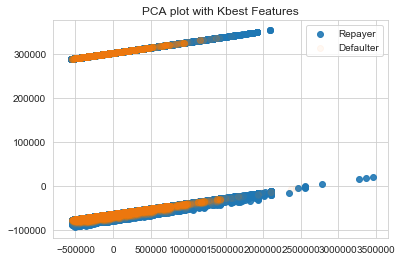

In [23]:
X_2d = PCA(n_components=2).fit_transform(trainX)

fig, ax = plt.subplots()
ax.scatter(X_2d[trainX.TARGET==0, 0], X_2d[trainX.TARGET==0, 1], alpha=0.9, label='Repayer')
ax.scatter(X_2d[trainX.TARGET==1, 0], X_2d[trainX.TARGET==1, 1], alpha=0.05, label='Defaulter')
ax.set(title='PCA plot with Kbest Features')
ax.legend()
plt.show()

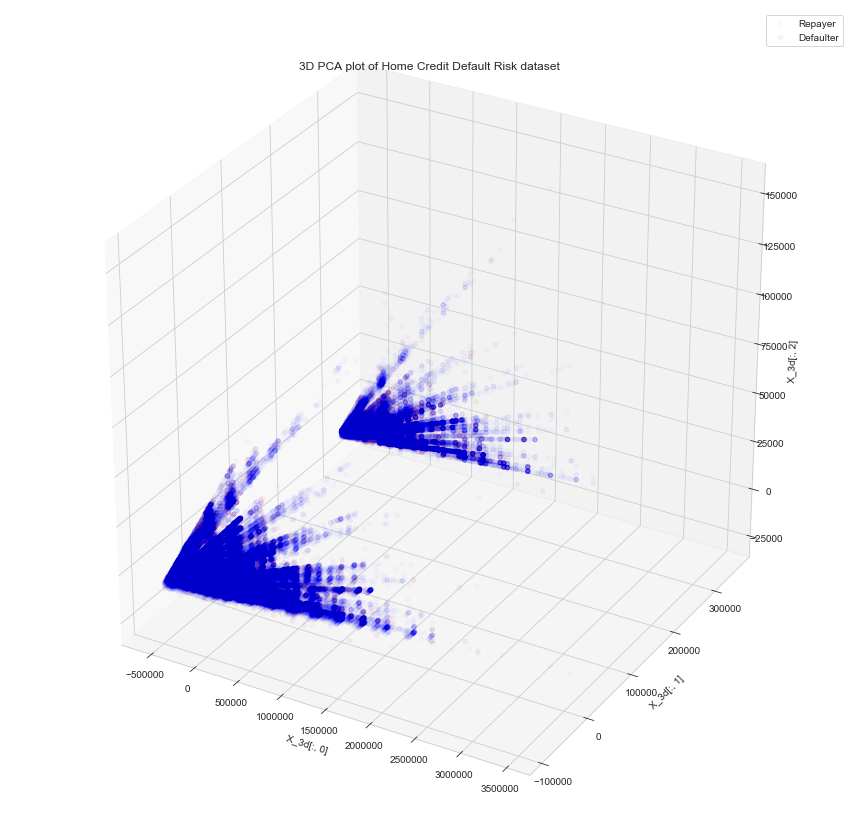

In [24]:
from mpl_toolkits.mplot3d import Axes3D

pca = PCA(n_components=3)
X_3d = pca.fit_transform(trainX)

fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X_3d[trainX.TARGET==0, 0], X_3d[trainX.TARGET==0, 1], X_3d[trainX.TARGET==0, 2], alpha=0.02, color='b', label='Repayer')
ax.scatter(X_3d[trainX.TARGET==1, 0], X_3d[trainX.TARGET==1, 1], X_3d[trainX.TARGET==1, 2], alpha=0.05, color='r', label='Defaulter')
ax.set(xlabel='X_3d[:, 0]', ylabel='X_3d[:, 1]', zlabel='X_3d[:, 2]',
       title='3D PCA plot of Home Credit Default Risk dataset')
ax.legend()

## 2. Resampling

In [25]:
#Due to Imbalance Data, we opted to resample
trainX_0 = trainX[trainX.TARGET==0].sample(frac=0.1, random_state = 1)
trainX_1 = trainX[trainX.TARGET==1].sample(frac=0.9, random_state = 1)

print('Shape of Training Dataset before resampling               :', trainX.shape)

print('Total Row of Training Dataset after resampling            :', trainX_0.shape[0] + trainX_1.shape[0])
print('Shape of Training Dataset for Target = 0 after resampling :', trainX_0.shape)
print('Shape of Training Dataset for Target = 1 after resampling :', trainX_1.shape)

Shape of Training Dataset before resampling               : (289693, 51)
Total Row of Training Dataset after resampling            : 47977
Shape of Training Dataset for Target = 0 after resampling : (26593, 51)
Shape of Training Dataset for Target = 1 after resampling : (21384, 51)


In [26]:
#Combined the resampled dataset and split into X and y dataset
data_resample = pd.concat([trainX_0, trainX_1], axis = 0)
trainX = data_resample.iloc[:, :]
trainY = data_resample.loc[:, 'TARGET']

print('Shape of TrainX after resampling', trainX.shape)
print('Shape of TrainY after resampling', trainY.shape)

Shape of TrainX after resampling (47977, 51)
Shape of TrainY after resampling (47977,)


## 3. Train and Test Split

In [27]:
X_train, X_test, y_train, y_test = train_test_split(trainX, trainY, test_size = 0.3, random_state = 0)

In [28]:
print('Shape of X_train after split', X_train.shape)
print('Shape of y_train after split', y_train.shape)
print('Shape of X_test after split', X_test.shape)
print('Shape of y_test after split', y_test.shape)

Shape of X_train after split (33583, 51)
Shape of y_train after split (33583,)
Shape of X_test after split (14394, 51)
Shape of y_test after split (14394,)


## 4. Feature Scaling

In [29]:
# Feature Scaling
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

## Modeling with MLP

In [30]:
model = Sequential()
model.add(Dense(units =10, kernel_initializer = 'uniform', activation = 'relu', input_dim = 51))
model.add(Dense(units = 10, kernel_initializer = 'uniform', activation = 'relu'))
model.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])


tensorboard = TensorBoard(log_dir='./logs/home_credit/%d' % time.time())
earlystopping = EarlyStopping(patience=2)
checkpoint = ModelCheckpoint('home-risk-{epoch:02d}-{loss:.4f}.hdf5',
                             monitor='loss', save_best_only=True, mode='min')


history = model.fit(X_train, y_train, batch_size = 10, epochs = 10, verbose=1, validation_data=(X_test, y_test), callbacks=[tensorboard, earlystopping, checkpoint])
model.summary()

score = model.evaluate(X_test, y_test, verbose=0) 
print('\nTest Score:', score[0]) 
print('Test Accuracy:', score[1])

Train on 33583 samples, validate on 14394 samples
Epoch 1/10
33583/33583 [==============================] - 6s 169us/step - loss: 0.0514 - acc: 0.9811 - val_loss: 0.0014 - val_acc: 0.9999
Epoch 2/10
33583/33583 [==============================] - 6s 169us/step - loss: 6.5262e-04 - acc: 1.0000 - val_loss: 3.1021e-04 - val_acc: 0.9999
Epoch 3/10
33583/33583 [==============================] - 6s 182us/step - loss: 1.0185e-04 - acc: 1.0000 - val_loss: 2.0170e-04 - val_acc: 0.9999
Epoch 4/10
33583/33583 [==============================] - 7s 195us/step - loss: 1.4915e-05 - acc: 1.0000 - val_loss: 2.4972e-04 - val_acc: 0.9999
Epoch 5/10
33583/33583 [==============================] - 5s 162us/step - loss: 2.4491e-06 - acc: 1.0000 - val_loss: 2.6833e-04 - val_acc: 0.9999
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 10)                520       
______________________________

In [31]:
# Predicting the Test set results
pred = model.predict(X_test)
y_pred = (pred > 0.5)
pred_classes = model.predict_classes(X_test)

             precision    recall  f1-score   support

        0.0       1.00      1.00      1.00      7999
        1.0       1.00      1.00      1.00      6395

avg / total       1.00      1.00      1.00     14394



[Text(0,0.5,'Repayer'), Text(0,1.5,'Defaulter')]

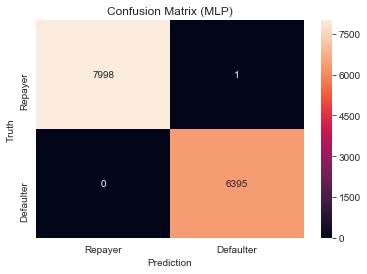

In [32]:
cm = confusion_matrix(y_test.values, pred_classes)
print(classification_report(y_test.values, pred_classes))

fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, ax=ax, fmt='d')

ax.set(xlabel='Prediction', ylabel='Truth', title='Confusion Matrix (MLP)'); 
ax.xaxis.set_ticklabels(['Repayer', 'Defaulter'])
ax.yaxis.set_ticklabels(['Repayer', 'Defaulter'])

<function matplotlib.pyplot.plot(*args, **kwargs)>

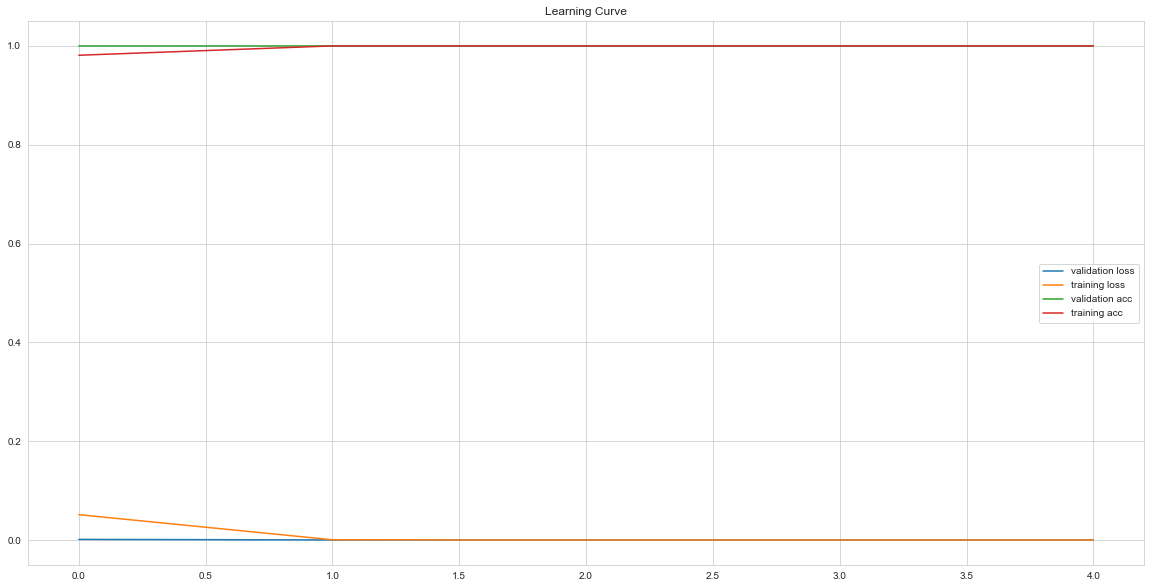

In [33]:
# Plot learning curve

fig, ax = plt.subplots(figsize=(20,10))
plt.plot(history.history['val_loss'], label='validation loss')
plt.plot(history.history['loss'], label='training loss')

plt.plot(history.history['val_acc'], label='validation acc')
plt.plot(history.history['acc'], label='training acc')
ax.legend()
ax.set_title('Learning Curve')

plt.legend()
plt.plot

## Modeling with Logistic Regression

In [34]:
logistic = LogisticRegression(random_state=42)
logistic.fit(X_train, y_train)
y_pred_logistic = logistic.predict(X_test)

             precision    recall  f1-score   support

        0.0       1.00      1.00      1.00      7999
        1.0       1.00      1.00      1.00      6395

avg / total       1.00      1.00      1.00     14394



[Text(0,0.5,'Repayer'), Text(0,1.5,'Defaulter')]

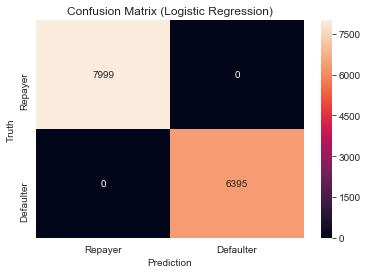

In [35]:
cm = confusion_matrix(y_test.values, y_pred_logistic)
print(classification_report(y_test, y_pred_logistic))

fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, ax=ax, fmt='d')

ax.set(xlabel='Prediction', ylabel='Truth', title='Confusion Matrix (Logistic Regression)'); 
ax.xaxis.set_ticklabels(['Repayer', 'Defaulter'])
ax.yaxis.set_ticklabels(['Repayer', 'Defaulter'])

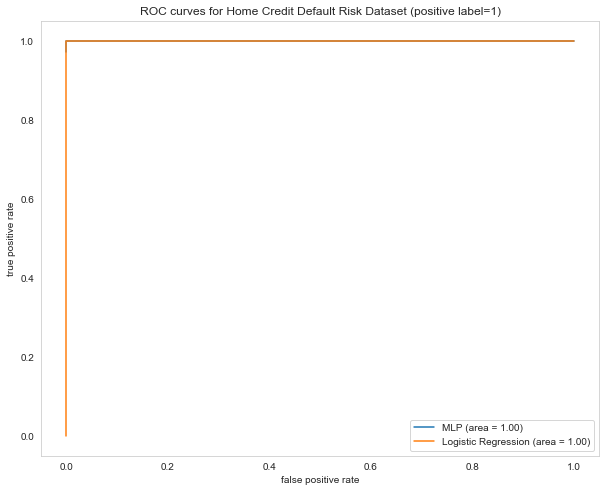

In [36]:
#MLP
y_confidence_mlp = model.predict_proba(X_test)
fpr_mlp, tpr_mlp, _ = roc_curve(y_test, y_confidence_mlp[:, :], pos_label=1)
auc_mlp = auc(fpr_mlp, tpr_mlp)

# Logistic Regression
y_confidence_lr = logistic.decision_function(X_test)
fpr_logistic, tpr_logistic, _ = roc_curve(y_test, y_confidence_lr, pos_label=1)
auc_logistic = auc(fpr_logistic, tpr_logistic)


# Plot the ROCs
fig, ax = plt.subplots(figsize=(10, 8))

ax.plot(fpr_mlp, tpr_mlp, label='MLP (area = %0.2f)' % auc_mlp)
ax.plot(fpr_logistic, tpr_logistic, label='Logistic Regression (area = %0.2f)' % auc_logistic)


# bigger area is better
ax.set(xlabel='false positive rate', ylabel='true positive rate',
       title='ROC curves for Home Credit Default Risk Dataset (positive label=1)')
ax.legend()
ax.grid()
plt.show()

## Prediction

In [37]:
predX= data_all[data_all['is_test'] == 1.][relevant_features]

# Feature Scaling
predX = sc.transform(predX)
print('Shape of Test Dataset     :', predX.shape)

pred_lr = logistic.predict(predX)
pred_mlp = model.predict_classes(predX)

# print predictions
print()
print('Logistic Regression', pred_lr)
print('MLP', pred_mlp)

Shape of Test Dataset     : (47762, 51)

Logistic Regression [0. 0. 0. ... 0. 0. 0.]
MLP [[0]
 [0]
 [0]
 ...
 [0]
 [0]
 [0]]
